Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [157]:
from random import choices
from random import choice, randint
from functools import reduce
from collections import namedtuple
from dataclasses import dataclass
from copy import copy
from tqdm import trange
from pprint import pprint
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
# import lab9_lib

In [97]:
# Copyright © 2023 Giovanni Squillero <giovanni.squillero@polito.it>
# https://github.com/squillero/computational-intelligence
# Free for personal or classroom use; see 'LICENSE.md' for details.

from abc import abstractmethod


class AbstractProblem:
    def __init__(self):
        self._calls = 0

    @property
    @abstractmethod
    def x(self):
        pass

    @property
    def calls(self):
        return self._calls

    @staticmethod
    def onemax(genome):
        return sum(bool(g) for g in genome)

    def __call__(self, genome):
        self._calls += 1
        fitnesses = sorted((AbstractProblem.onemax(genome[s :: self.x]) for s in range(self.x)), reverse=True)
        val = sum(f for f in fitnesses if f == fitnesses[0]) - sum(
            f * (0.1 ** (k + 1)) for k, f in enumerate(f for f in fitnesses if f < fitnesses[0])
        )
        return val / len(genome)


def make_problem(a):
    class Problem(AbstractProblem):
        @property
        @abstractmethod
        def x(self):
            return a

    return Problem()

In [98]:
N_GENERATIONS = 50_000
GENES = 1_000
POPULATION_SIZE = 30
OFFSPRING_SIZE = 20
TOURNAMENT_SIZE = 2
MUTATION_PROBABILITY = .15

In [173]:
@dataclass
class Individual:
    fitness: tuple
    genotype: list[bool]

def select_parent(pop):
    pool = [choice(pop) for _ in range(TOURNAMENT_SIZE)]
    champion = max(pool, key=lambda i: i.fitness)
    return champion

def mutate(ind: Individual) -> Individual:
    offspring = copy(ind)
    mut_point = random.sample(range(1, GENES-1), NUM_MUTS)
    for pos in mut_point:
        offspring.genotype[pos] = abs(offspring.genotype[pos] - 1)
    offspring.fitness = None
    return offspring

def one_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    cut_point = randint(0, GENES-1)
    offspring = Individual(fitness=None,
                           genotype=ind1.genotype[:cut_point] + ind2.genotype[cut_point:])
    assert len(offspring.genotype) == GENES
    return offspring

def create_offspring(ind_list: list, cut_points: list )-> Individual:
    offspring_genotype = []
    for i in range(len(ind_list)):
        offspring_genotype.extend(ind_list[i].genotype[cut_points[i]:cut_points[i+1]])
    
    offspring = Individual(fitness=None,
                           genotype=offspring_genotype)
    return offspring

def cut_multiple(ind_list: list) -> Individual:
    cut_points = random.sample(range(1, GENES-1), len(ind_list)-1)
    cut_points.sort()
    cut_points[:0] = [0]
    cut_points.append(GENES)
    offspring = create_offspring(ind_list, cut_points)
    assert len(offspring.genotype) == GENES
    return offspring

def create_population(genes):
    population = [
        Individual(
            genotype=choices([0, 1], k=genes),
            fitness=None,
        )
        for _ in range(POPULATION_SIZE)
    ]


    for i in population:
        i.fitness = fitness(i.genotype)
    
    return population

def plot_fitness(fitnesses: list) -> None:

    plt.plot(fitnesses, label=f'Problem Instances={PROBLEMS}')
    plt.title("Best Fitness Values")
    plt.xlabel("Steps")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend()
    plt.show()


In [198]:
N_GENERATIONS = 50_000
GENES = 1_000
POPULATION_SIZE = 600
OFFSPRING_SIZE = 400
TOURNAMENT_SIZE = 20
PATIENCE = 10
NUM_MUTS = 10
MUT_SPRINGS = 100
PROBLEMS = 1


fitness = make_problem(PROBLEMS)
population = create_population(GENES)
pbar = trange(N_GENERATIONS)
mutation = False
best_fitnesses = []
best_fit = 0
p_count = 0
m_count = 0
tot_mutations=0

for generation in pbar:
    offspring = list()
    for counter in range(OFFSPRING_SIZE):
        if mutation:  
            p = select_parent(population)
            o = mutate(p)
            m_count += 1
            if m_count>=MUT_SPRINGS:
                m_count=0
                p_count=0
                mutation=False
        else:
            pops = [select_parent(population) for _ in range(TOURNAMENT_SIZE)]
            o = cut_multiple(pops)
        offspring.append(o)

    for i in offspring:
        i.fitness = fitness(i.genotype)
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness, reverse=True)
    population = population[:POPULATION_SIZE]
    if population[0].fitness <= best_fit:
        p_count+=1
    if p_count == PATIENCE:
        mutation = True
        tot_mutations+=1
    best_fit = population[0].fitness
    best_fitnesses.append(population[0].fitness)
    pbar.set_postfix({f"fitness": f"{best_fit:.2%}", f"calls": f"{fitness.calls}"})
    pbar.update(0)
    if tot_mutations>10 or best_fit==1:
        break
    

  0%|        | 185/50000 [00:24<1:48:03,  7.68it/s, fitness=99.40%, calls=75000]


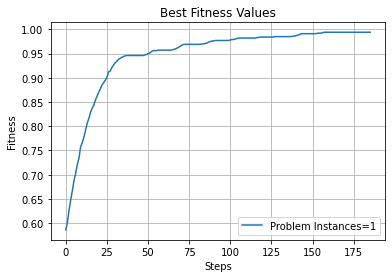

In [199]:
plot_fitness(best_fitnesses)

In [203]:
N_GENERATIONS = 50_000
GENES = 1_000
POPULATION_SIZE = 600
OFFSPRING_SIZE = 400
TOURNAMENT_SIZE = 20
PATIENCE = 10
NUM_MUTS = 10
MUT_SPRINGS = 100
PROBLEMS = 2


fitness = make_problem(PROBLEMS)
population = create_population(GENES)
pbar = trange(N_GENERATIONS)
mutation = False
best_fitnesses = []
best_fit = 0
p_count = 0
m_count = 0
tot_mutations=0

for generation in pbar:
    offspring = list()
    for counter in range(OFFSPRING_SIZE):
        if mutation:  
            p = select_parent(population)
            o = mutate(p)
            m_count += 1
            if m_count>=MUT_SPRINGS:
                m_count=0
                p_count=0
                mutation=False
        else:
            pops = [select_parent(population) for _ in range(TOURNAMENT_SIZE)]
            o = cut_multiple(pops)
        offspring.append(o)

    for i in offspring:
        i.fitness = fitness(i.genotype)
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness, reverse=True)
    population = population[:POPULATION_SIZE]
    if population[0].fitness <= best_fit:
        p_count+=1
    if p_count == PATIENCE:
        mutation = True
        tot_mutations+=1
    best_fit = population[0].fitness
    best_fitnesses.append(population[0].fitness)
    pbar.set_postfix({f"fitness": f"{best_fit:.2%}", f"calls": f"{fitness.calls}"})
    pbar.update(0)
    if tot_mutations>50 or best_fit==1:
        break
    

  1%|       | 566/50000 [01:11<1:43:55,  7.93it/s, fitness=83.60%, calls=227400]


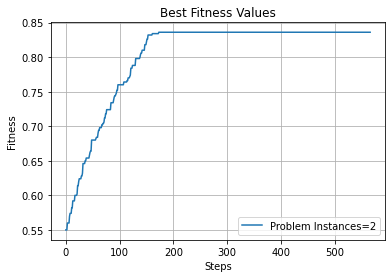

In [204]:
plot_fitness(best_fitnesses)

In [208]:
N_GENERATIONS = 50_000
GENES = 1_000
POPULATION_SIZE = 900
OFFSPRING_SIZE = 700
TOURNAMENT_SIZE = 30
PATIENCE = 10
NUM_MUTS = 5
MUT_SPRINGS = 400
PROBLEMS = 5


fitness = make_problem(PROBLEMS)
population = create_population(GENES)
pbar = trange(N_GENERATIONS)
mutation = False
best_fitnesses = []
best_fit = 0
p_count = 0
m_count = 0
tot_mutations=0

for generation in pbar:
    offspring = list()
    for counter in range(OFFSPRING_SIZE):
        if mutation:  
            p = select_parent(population)
            o = mutate(p)
            m_count += 1
            if m_count>=MUT_SPRINGS:
                m_count=0
                p_count=0
                mutation=False
        else:
            pops = [select_parent(population) for _ in range(TOURNAMENT_SIZE)]
            o = cut_multiple(pops)
        offspring.append(o)

    for i in offspring:
        i.fitness = fitness(i.genotype)
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness, reverse=True)
    population = population[:POPULATION_SIZE]
    if population[0].fitness <= best_fit:
        p_count+=1
    if p_count == PATIENCE:
        mutation = True
        tot_mutations+=1
    best_fit = population[0].fitness
    best_fitnesses.append(population[0].fitness)
    pbar.set_postfix({f"fitness": f"{best_fit:.2%}", f"calls": f"{fitness.calls}"})
    pbar.update(0)
    if tot_mutations>50 or best_fit==1:
        break
    

  1%|       | 514/50000 [03:04<4:56:16,  2.78it/s, fitness=50.50%, calls=361400]


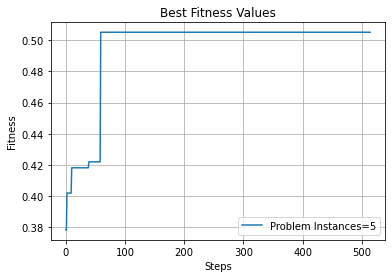

In [209]:
plot_fitness(best_fitnesses)

In [214]:
N_GENERATIONS = 50_000
GENES = 1_000
POPULATION_SIZE = 1000
OFFSPRING_SIZE = 600
TOURNAMENT_SIZE = 20
PATIENCE = 10
NUM_MUTS = 2
MUT_SPRINGS = 300
PROBLEMS = 10


fitness = make_problem(PROBLEMS)
population = create_population(GENES)
pbar = trange(N_GENERATIONS)
mutation = False
best_fitnesses = []
best_fit = 0
p_count = 0
m_count = 0
tot_mutations=0

for generation in pbar:
    offspring = list()
    for counter in range(OFFSPRING_SIZE):
        if mutation:  
            p = select_parent(population)
            o = mutate(p)
            m_count += 1
            if m_count>=MUT_SPRINGS:
                m_count=0
                p_count=0
                mutation=False
        else:
            pops = [select_parent(population) for _ in range(TOURNAMENT_SIZE)]
            o = cut_multiple(pops)
        offspring.append(o)

    for i in offspring:
        i.fitness = fitness(i.genotype)
    population.extend(offspring)
    population.sort(key=lambda i: i.fitness, reverse=True)
    population = population[:POPULATION_SIZE]
    if population[0].fitness <= best_fit:
        p_count+=1
    if p_count == PATIENCE:
        mutation = True
        tot_mutations+=1
    best_fit = population[0].fitness
    best_fitnesses.append(population[0].fitness)
    pbar.set_postfix({f"fitness": f"{best_fit:.2%}", f"calls": f"{fitness.calls}"})
    pbar.update(0)
    if tot_mutations>50 or best_fit==1:
        break
    

  1%|       | 518/50000 [01:32<2:27:37,  5.59it/s, fitness=37.23%, calls=312400]


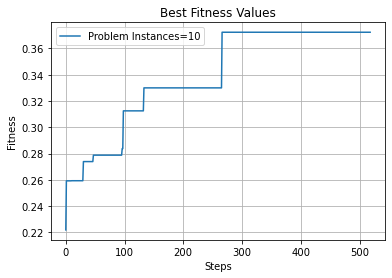

In [215]:
plot_fitness(best_fitnesses)